# Imports

In [14]:
import os
# Run on CPU
os.environ['CUDA_VISIBLE_DEVICES'] = "-1"

import cv2
import numpy as np
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Input, Dense, Dropout, Conv2D, MaxPooling2D, Flatten, BatchNormalization
from keras.layers import Rescaling, Resizing, RandomFlip, RandomRotation

from tensorflow.image import rgb_to_grayscale

from sklearn.preprocessing import MinMaxScaler

from utils.model_utils import plot_history

# Carregamento de dados

In [3]:
dataset_path = os.path.join(
    os.getcwd(), 'datasets', 'simpsons', 'images'
)
bart_test_set_path = os.path.join(dataset_path, 'test_set', 'bart')
homer_test_set_path = os.path.join(dataset_path, 'test_set', 'homer')
bart_training_set_path = os.path.join(dataset_path, 'training_set', 'bart')
homer_training_set_path = os.path.join(dataset_path, 'training_set', 'homer')

test_files = [os.path.join(bart_test_set_path, file) for file in os.listdir(bart_test_set_path)]
for file in os.listdir(homer_test_set_path):
    test_files.append(os.path.join(homer_test_set_path, file))

train_files = [os.path.join(bart_training_set_path, file) for file in os.listdir(bart_training_set_path)]
for file in os.listdir(homer_training_set_path):
    train_files.append(os.path.join(homer_training_set_path, file))

# Tratamento dos dados

## Normalização

In [8]:
width, height = 128, 128



def normalize_dataset(files):
    images = []
    labels = []
    scaler = MinMaxScaler()

    for file in files:
        image = cv2.imread(file)
        # Redimenciona a imagem
        image = cv2.resize(image, (width, height))
        # Converte para escala de cinza
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        # Normalizing values between 0 and 1
        image = scaler.fit_transform(image)
        # image = image / 255
        # Converte a matriz para um vetor
        image = image.ravel()
        

        images.append(image)

        # Get the label
        file_name = os.path.basename(os.path.normpath(file))
        label = 1 if file_name.startswith('h') else 0
        labels.append(label)
    
    return np.asarray(images), np.asarray(labels)
        
X_test, y_test = normalize_dataset(test_files)
X_train, y_train = normalize_dataset(train_files)


## Visualização das imagens geradas

In [4]:

index = np.random.randint(0, X_test.shape[0])


cv2.imshow("teste", X_test[index].reshape((height, width)))
cv2.waitKey(0)
cv2.destroyAllWindows()

# Método 1 - Rede Neural Densa

In [19]:
model1 = Sequential(
    layers=[
        Input(
            shape = (X_train.shape[1],)
        ),
    ]
)

model1.add(
    Dense(
        units= 8193,
        activation = 'relu'
    )
)
model1.add(
    Dropout(0.25)
)

model1.add(
    Dense(
        units= 8193,
        activation = 'relu'
    )
)
model1.add(
    Dropout(0.25)
)

model1.add(
    Dense(
        units=1,
        activation = 'sigmoid'
    )
)

model1.compile(
    optimizer='Adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)


In [20]:
model1.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 8193)           │   134,242,305 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 8193)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 8193)           │    67,133,442 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 8193)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │         8,194 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 201,383,941 (768.22 MB)

 Trainable params: 201,383,941 (768.22 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
resultado = model1.fit(
    x=X_train, 
    y=y_train, 
    epochs=50
)

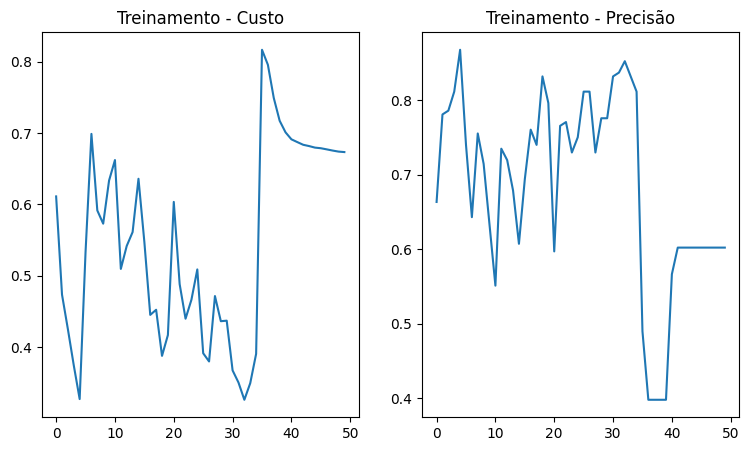

In [ ]:
historico = resultado.history
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(9, 5), sharex=True)

ax1.plot(historico['loss'])
ax1.set_title('Treinamento - Custo')

ax2.plot(historico['accuracy'])
ax2.set_title('Treinamento - Precisão')

plt.show()

In [ ]:
resultado = model1.evaluate(X_test, y_test)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.7017 - loss: 0.6463


# Método 2 - Rede Neural Convulocional

## Data Normalization and Augmentation

In [24]:
width, height = 128, 128

# https://www.tensorflow.org/tutorials/images/data_augmentation?hl=pt-br#resizing_and_rescaling
resize_rescale = Sequential([
    Resizing(height=height, width=width, data_format="channels_last", dtype=np.float32),
    Rescaling(1./255)
])

data_augmentation = Sequential([
    RandomFlip("horizontal_and_vertical"),
    RandomRotation(0.2),
])

def parse_dataset(files, augment=False):
    images = []
    labels = []

    for file in files:
        # Get the label
        file_name = os.path.basename(os.path.normpath(file))
        label = 1 if file_name.startswith('h') else 0
        labels.append(label)

        image = cv2.imread(file)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = image.astype('float32')

        # Normalizing values between 0 and 1
        image = resize_rescale(image)

        # Converte para escala de cinza
        image = rgb_to_grayscale(image)
        


        images.append(image)

        if augment:
            # Data Augmentation
            for i in range(3):
                augmented_image = data_augmentation(image)
                images.append(augmented_image)
                labels.append(label)        
    
    return np.asarray(images), np.asarray(labels)
        
X_test, y_test = parse_dataset(test_files)
X_train, y_train = parse_dataset(train_files, augment=True)

In [25]:
print("Test shape: ", X_test.shape)
print("Train shape: ", X_train.shape)

print("Total Images: ", X_test.shape[0] + X_train.shape[0])

Test shape:  (73, 128, 128, 1)
Train shape:  (784, 128, 128, 1)
Total Images:  857


## Modelo

In [26]:
model2 = Sequential(
    name="CNN",
    layers=[
        Input(
            shape = (128, 128, 1)
        )
    ]
)

model2.add(
    Conv2D(
        filters=32,
        kernel_size=(3, 3),
        activation="relu"
    )
)
model2.add(
    BatchNormalization()
)
model2.add(
    MaxPooling2D(
        pool_size=(2, 2),

    )
)
model2.add(
    Flatten()
)

# ANN
model2.add(
    Dense(
        units= 128, # 8193,
        activation = 'relu'
    )
)
model2.add(
    Dropout(0.25)
)

model2.add(
    Dense(
        units= 128, # 8193,
        activation = 'relu'
    )
)
model2.add(
    Dropout(0.25)
)

model2.add(
    Dense(
        units=1,
        activation = 'sigmoid'
    )
)

model2.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model2.summary()


Model: "CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 126, 126, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 127008)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    16,257,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,274,241 (62.08 MB)

 Trainable params: 16,274,177 (62.08 MB)

 Non-trainable params: 64 (256.00 B)

In [28]:
resultados = model2.fit(
    x=X_train, 
    y=y_train, 
    epochs=50,
    batch_size=32,
    validation_data=(X_test, y_test),
    validation_batch_size=32
)

Epoch 1/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 11s 377ms/step - accuracy: 0.5745 - loss: 2.9854 - val_accuracy: 0.5342 - val_loss: 0.6819
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 9s 362ms/step - accuracy: 0.7299 - loss: 1.0943 - val_accuracy: 0.4521 - val_loss: 0.9818
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.8786 - loss: 0.4139 - val_accuracy: 0.4247 - val_loss: 1.3142
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 9s 361ms/step - accuracy: 0.9176 - loss: 0.2461 - val_accuracy: 0.4247 - val_loss: 1.8438
Epoch 5/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 9s 360ms/step - accuracy: 0.9366 - loss: 0.1880 - val_accuracy: 0.4521 - val_loss: 1.3278
Epoch 6/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 9s 361ms/step - accuracy: 0.9786 - loss: 0.0369 - val_accuracy: 0.4521 - val_loss: 1.4683
Epoch 7/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 9s 350ms/step - accuracy: 0.9776 - loss: 0.0499 - val_accuracy: 0.4521 - val_loss: 1.5989
Epoch 8/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 9s 355ms/step - accuracy: 0.9850 - loss: 0.0584 - val_accuracy: 0

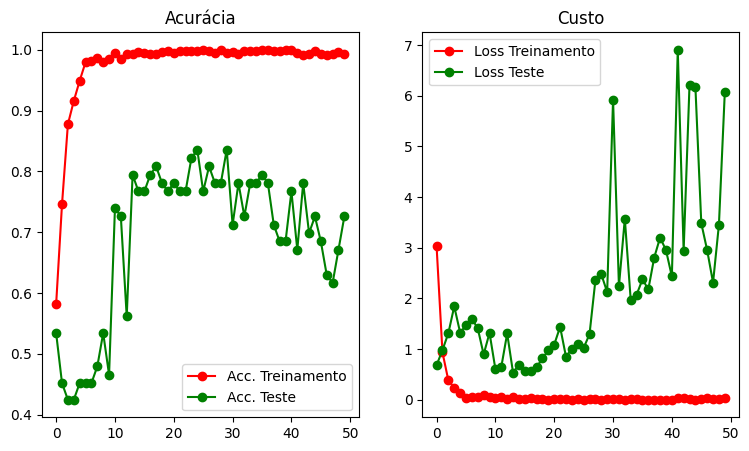

In [30]:
historico = resultados

plot_history(historico)